<a href="https://colab.research.google.com/github/ariegever/ImageProcessing_Project/blob/main/2_unet_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# === HOW TO USE THIS NOTEBOOK ===
#
# 1.  **Check Your Assets:**
#     * Go to your Earth Engine Assets tab.
#     * You must have 3 assets uploaded:
#         1. Your Sentinel-2 Image
#         2. Your Sentinel-1 Image
#         3. Your Land Cover Mask
#     * Get the Asset ID for each one (e.g., "projects/...")
#
# 2.  **Fill in "Cell 5: USER CONFIGURATION":**
#     * You MUST provide your:
#         * GCP Project ID.
#         * The three Earth Engine Asset IDs from Step 1.
#         * A path in your Google Drive where you want to save the output.
#
# 3.  **Run "Cell 6: Upload lc.json":**
#     * Run this cell, then use the file explorer on the left to
#       drag-and-drop your REAL `lc.json` file into the `/content/` folder.
#
# 4.  **Run All Cells (in order):**
#     * **Run Cell 9 (Verify Band Names) carefully.**
#     * **You MUST copy-paste the band names** from its output
#       back into the `S2_BANDS` and `S1_BANDS` lists in **Cell 5**.
#
# 5.  **Run the Pipeline:**
#     * The script will save the final `.tfrecord.gz` file to the
#       Google Drive path you specified.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
import google.auth
import ee
# Trigger the authentication flow.
auth.authenticate_user()
PROJECT = "ivory-scion-476708-t5"
# Get credentials and initialize Earth Engine
credentials, project = google.auth.default()
ee.Initialize(credentials, project=PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

print(f"Successfully initialized Earth Engine for project: {PROJECT}")

Mounted at /content/drive
Successfully initialized Earth Engine for project: ivory-scion-476708-t5


In [ ]:
import json
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import io
import requests
import concurrent.futures
from google.api_core import retry
from numpy.lib import recfunctions as rfn
from PIL import ImageColor
from matplotlib.colors import ListedColormap
from skimage.exposure import rescale_intensity

In [ ]:
# === 1. Google Cloud Project ===

PROJECT = 'ivory-scion-476708-t5'  # <-- 1. REPLACE with your GCP Project ID

# --- 2. Google Drive Output Path ---

# This is the folder in your Drive where outputs will be saved.
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images' # <-- 2. REPLACE IF YOU WANT

# --- 3. Earth Engine Asset Paths ---
YEAR = 2020
S2_ASSET_PATH = 'projects/ivory-scion-476708-t5/assets/east_negev_Sentinel2_2020' # <-- 3. REPLACE
S1_ASSET_PATH = 'projects/ivory-scion-476708-t5/assets/east_negev_Sentinel1_2020'
LC_ASSET_PATH = 'projects/ivory-scion-476708-t5/assets/lc_map' # <-- 5. REPLACE

# --- 4. Patch & Sampling Parameters ---

PATCH_SIZE = 128  # Size of the patches (128x128 pixels)
SCALE = 10      # Resolution in meters (10m for S2)
IMAGE_PER_LC = 20 # Number of patches to sample *per land cover class*

# --- 5. Band Definitions ---
#
# !!! RUN CELL 9 FIRST !!!
# Then, copy-paste the band names from its output into these lists.
#
# Example for Sentinel-2 (12 bands):
S2_BANDS = [
 'B2', 'B3', 'B4', 'B8', 'B11', 'B12'
]
#
S1_BANDS = [
    'VV', 'VH'
]
#
# These are created automatically:
FEATURE_NAMES = S2_BANDS + S1_BANDS
LABEL_NAME = 'label'

# --- 6. File Paths (Colab & Drive) ---
CLASS_JSON_PATH = '/content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/lcs/dict_land_cover.json'  # Local path in Colab for your lc.json file
POINTS_ASSET_PATH = 'projects/ivory-scion-476708-t5/assets/sample_points'
# Create the output directory in Google Drive
os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)
OUTPUT_FILE = os.path.join(DRIVE_PROJECT_PATH, f'S2_S1_patches_{YEAR}.tfrecord.gz')

print(f"Project: {PROJECT}")
print(f"Feature bands: {FEATURE_NAMES}")
print(f"Output will be saved to: {OUTPUT_FILE}")
print(f" expecting coordinates at: {POINTS_ASSET_PATH}")

Project: ivory-scion-476708-t5
Feature bands: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'VV', 'VH']
Output will be saved to: /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/S2_S1_patches_2020.tfrecord.gz
 expecting coordinates at: projects/ivory-scion-476708-t5/assets/sample_points


In [ ]:
import json
import pandas as pd
from matplotlib.colors import ListedColormap


try:
    with open(CLASS_JSON_PATH) as f:
        lc = json.load(f)
except FileNotFoundError:
    print(f"ERROR: '{CLASS_JSON_PATH}' not found.")
    raise
except json.JSONDecodeError:
    print(f"ERROR: '{CLASS_JSON_PATH}' is not a valid JSON file.")
    raise

# Load from a dict (object) instead of a list
lc_df = pd.DataFrame.from_dict(lc, orient='index')

# Rename your columns to match what the script expects
lc_df = lc_df.rename(columns={'class': 'label', 'color': 'palette'})

# This line IS THE SAME AS YOUR SCRIPT. It creates new normalized values 1, 2, 3, 4, 5
lc_df["values_normalize"] = lc_df.index.astype(int) + 1

from_values = []
to_values = []

for index, row in lc_df.iterrows():
    # Get the new value this script just created (1, 2, 3, 4, or 5)
    new_normalized_value = row['values_normalize']

    # Find all original values that map to it
    for original_class in row['original_classes']:
        from_values.append(original_class['values'])
        to_values.append(new_normalized_value)

# Get palette for plotting
palette_hex = lc_df["palette"].to_list()

cmap = ListedColormap(palette_hex)
vmin = 1
vmax = len(palette_hex) # This will be 5

print(f"Loaded {len(lc_df)} AGGREGATED classes from {CLASS_JSON_PATH}.")
print(f"Remapping {from_values} -> {to_values}")
lc_df



Loaded 5 AGGREGATED classes from /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/lcs/dict_land_cover.json.
Remapping [11, 21, 22, 23, 24, 31, 32, 41, 42, 43, 51, 52] -> [1, 2, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5]


,label,palette,values_normalize,original_classes
0,Built-up,#E60000,1,"[{'class': 'Built up and road surface', 'color..."
1,Disturbed,#B22222,2,"[{'class': 'Transportation disturbed', 'color'..."
2,Natural and wooded,#006400,3,"[{'class': 'Natural', 'color': '#006400', 'val..."
3,Agriculture,#ADFF2F,4,"[{'class': 'Cropland', 'color': '#ADFF2F', 'va..."
4,Water,#0000FF,5,"[{'class': 'Natural water surface', 'color': '..."


In [ ]:
# 1. Load the S2, S1, and Land Cover images
try:
    s2_image = ee.Image(S2_ASSET_PATH).select(S2_BANDS)
    s1_image = ee.Image(S1_ASSET_PATH).select(S1_BANDS)
    lc_image = ee.Image(LC_ASSET_PATH) # This should be a single-band image
except ee.EEException as e:
    print(f"Error loading assets: {e}")
    print("Check your Asset Paths in Cell 5. Also, ensure the bands in")
    print("S2_BANDS and S1_BANDS exist in those assets.")
    print("Run Cell 9 to find the correct band names.")
    raise

# 2. Combine S1 and S2 into one feature image
feature_image = s2_image.addBands(s1_image)

# 3. Remap the land cover image
lc_remapped = lc_image.remap(from_values, to_values, 0, lc_image.bandNames().get(0))
lc_remapped = lc_remapped.rename(LABEL_NAME).toUint8() # Rename band to 'label'

# 4. Stack all bands into one image (features + label)
all_bands_image = feature_image.addBands(lc_remapped)

ALL_BANDS = FEATURE_NAMES + [LABEL_NAME]
print("Earth Engine assets loaded and stacked.")
print(f"Total bands in stacked image: {ALL_BANDS}")

Earth Engine assets loaded and stacked.
Total bands in stacked image: ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'VV', 'VH', 'label']


In [ ]:
# Pre-compute a geographic coordinate system.
proj = ee.Projection('EPSG:4326').atScale(SCALE).getInfo()

# Get scales in degrees out of the transform.
SCALE_X = proj['transform'][0]
SCALE_Y = -proj['transform'][4]

# Offset to the upper left corner of the patch.
OFFSET_X = -SCALE_X * PATCH_SIZE / 2
OFFSET_Y = -SCALE_Y * PATCH_SIZE / 2

# Request template. This defines the "grid" (patch) we want.
REQUEST_TEMPLATE = {
    'fileFormat': 'NPY',
    'grid': {
        'dimensions': {
            'width': PATCH_SIZE,
            'height': PATCH_SIZE
        },
        'affineTransform': {
            'scaleX': SCALE_X,
            'shearX': 0,
            'shearY': 0,
            'scaleY': SCALE_Y,
        },
        'crsCode': proj['crs']
    }
}

@retry.Retry()
def get_patch(coords, image):
  """Get a patch centered on the coordinates, as a numpy array."""
  request = dict(REQUEST_TEMPLATE) # Start with the template
  request['expression'] = image.select(ALL_BANDS) # Select all bands
  # Set the origin of the patch grid
  request['grid']['affineTransform']['translateX'] = coords[0] + OFFSET_X
  request['grid']['affineTransform']['translateY'] = coords[1] + OFFSET_Y

  # Fetch the patch from Earth Engine
  return np.load(io.BytesIO(ee.data.computePixels(request)))

print("Patch extraction functions defined.")

Patch extraction functions defined.


In [ ]:

def load_coords_from_asset(asset_path):
    """
    Loads a FeatureCollection asset and extracts the [lon, lat]
    coordinates from each feature.

    Assumes the asset is already projected to EPSG:4326.
    """
    print(f"Loading coordinates from EE Asset: {asset_path}...")
    try:
        ee_fc = ee.FeatureCollection(asset_path)
    except Exception as e:
        print(f"Error loading asset: {e}")
        print("Please check your `POINTS_ASSET_PATH` in Cell 5.")
        return []

    # Get the coordinates from the resulting FeatureCollection
    print("Fetching coordinates from server...")
    try:
        geometries = ee_fc.aggregate_array('.geo').getInfo()
    except Exception as e:
        print(f"Error fetching geometries: {e}")
        return []

    # The output is a list of {'type': 'Point', 'coordinates': [lon, lat]}
    # We just need the [lon, lat] part
    lon_lat_list = [item['coordinates'] for item in geometries]

    print(f"Successfully fetched {len(lon_lat_list)} coordinates from asset.")
    return lon_lat_list


In [ ]:
def array_to_example(structured_array):
  """Serialize a structured numpy array into a tf.Example proto."""
  feature = {}

  # Create default "empty" patches of all zeros
  default_float_patch = np.zeros(PATCH_SIZE * PATCH_SIZE, dtype=np.float32)
  default_int_patch = np.zeros(PATCH_SIZE * PATCH_SIZE, dtype=np.int64)

  # Loop through all expected FEATURE bands
  for f in FEATURE_NAMES:
    if (f in structured_array.dtype.names and
        structured_array[f].size == PATCH_SIZE * PATCH_SIZE):

        patch_data = structured_array[f].flatten().astype(np.float32)
    else:
        print(f"Warning: Missing or malformed feature '{f}' in a patch. Using zeros.")
        patch_data = default_float_patch

    feature[f] = tf.train.Feature(
        float_list=tf.train.FloatList(value=patch_data))

  # Do the same for the LABEL band
  if (LABEL_NAME in structured_array.dtype.names and
      structured_array[LABEL_NAME].size == PATCH_SIZE * PATCH_SIZE):

      patch_data = structured_array[LABEL_NAME].flatten().astype(np.int64)
  else:
      print(f"Warning: Missing or malformed feature '{LABEL_NAME}' in a patch. Using zeros.")
      patch_data = default_int_patch

  feature[LABEL_NAME] = tf.train.Feature(
      int64_list=tf.train.Int64List(value=patch_data))

  return tf.train.Example(
      features=tf.train.Features(feature=feature))


def write_dataset(image, sample_points, file_name, max_threads=20):
  """Write patches at the sample points into a TFRecord file."""
  print(f"\nStarting parallel patch extraction for {len(sample_points)} points...")
  print(f"Using {max_threads} threads...")

  EXECUTOR = concurrent.futures.ThreadPoolExecutor(max_workers=max_threads)

  future_to_point = {
      EXECUTOR.submit(get_patch, point_coords, image): point_coords
      for point_coords in sample_points
  }

  options = tf.io.TFRecordOptions(compression_type="GZIP")

  with tf.io.TFRecordWriter(file_name, options) as writer:
    count = 0
    total = len(future_to_point)

    for future in concurrent.futures.as_completed(future_to_point):
      try:
        np_array = future.result()
        if np_array.size == 0:
            print("  Skipping empty patch.")
            continue

        example_proto = array_to_example(np_array)
        writer.write(example_proto.SerializeToString())
        count += 1
        if count % 10 == 0 or count == total:
            print(f"  Processed {count} / {total} patches...")

      except Exception as e:
        print(f"Error processing patch: {e}")
        pass

  writer.close()
  print(f"\nSuccessfully wrote {count} patches to {file_name}")

In [ ]:

# 1. Get the list of [lon, lat] coordinates from your EE Asset
sample_coords = load_coords_from_asset(POINTS_ASSET_PATH)

if sample_coords:
    # 2. Write the dataset
    # We use the full stacked image (S1+S2+label) for this
    write_dataset(
        image=all_bands_image,
        sample_points=sample_coords,
        file_name=OUTPUT_FILE
    )

    print(f"\n--- Pipeline Complete ---")
    print(f"Your file is saved at: {OUTPUT_FILE}")
else:
    print("No coordinates were loaded from asset. Halting execution.")

Loading coordinates from EE Asset: projects/ivory-scion-476708-t5/assets/sample_points...
Fetching coordinates from server...
Successfully fetched 2535 coordinates from asset.

Starting parallel patch extraction for 2535 points...
Using 20 threads...
  Processed 10 / 2535 patches...
  Processed 20 / 2535 patches...
  Processed 30 / 2535 patches...
  Processed 40 / 2535 patches...
  Processed 50 / 2535 patches...
  Processed 60 / 2535 patches...
  Processed 70 / 2535 patches...
  Processed 80 / 2535 patches...
  Processed 90 / 2535 patches...
  Processed 100 / 2535 patches...
  Processed 110 / 2535 patches...
  Processed 120 / 2535 patches...
  Processed 130 / 2535 patches...
  Processed 140 / 2535 patches...
  Processed 150 / 2535 patches...
  Processed 160 / 2535 patches...
  Processed 170 / 2535 patches...
  Processed 180 / 2535 patches...
  Processed 190 / 2535 patches...
  Processed 200 / 2535 patches...
  Processed 210 / 2535 patches...
  Processed 220 / 2535 patches...
  Processe

  Processed 510 / 2535 patches...


  Processed 520 / 2535 patches...
  Processed 530 / 2535 patches...
  Processed 540 / 2535 patches...
  Processed 550 / 2535 patches...
  Processed 560 / 2535 patches...
  Processed 570 / 2535 patches...
  Processed 580 / 2535 patches...
  Processed 590 / 2535 patches...
  Processed 600 / 2535 patches...
  Processed 610 / 2535 patches...
  Processed 620 / 2535 patches...
  Processed 630 / 2535 patches...
  Processed 640 / 2535 patches...
  Processed 650 / 2535 patches...
  Processed 660 / 2535 patches...
  Processed 670 / 2535 patches...
  Processed 680 / 2535 patches...
  Processed 690 / 2535 patches...
  Processed 700 / 2535 patches...
  Processed 710 / 2535 patches...
  Processed 720 / 2535 patches...
  Processed 730 / 2535 patches...
  Processed 740 / 2535 patches...
  Processed 750 / 2535 patches...
  Processed 760 / 2535 patches...
  Processed 770 / 2535 patches...
  Processed 780 / 2535 patches...
  Processed 790 / 2535 patches...
  Processed 800 / 2535 patches...
  Processed 81

Reading back /content/drive/MyDrive/Image processing course 001-2-9301/project/u-net/data/images/S2_S1_patches_2020.tfrecord.gz to verify...
Displaying 10 sample patches...

--- S2 Band Statistics (First Patch) ---
  Red (B4)  - Min: 0.1150, Max: 0.5121, Mean: 0.3087
  Green (B3) - Min: 0.0942, Max: 0.4638, Mean: 0.2356
  Blue (B2) - Min: 0.0646, Max: 0.4024, Mean: 0.1689
------------------------------------------
Based on these stats, adjust the 'in_range' argument below for better visuals.


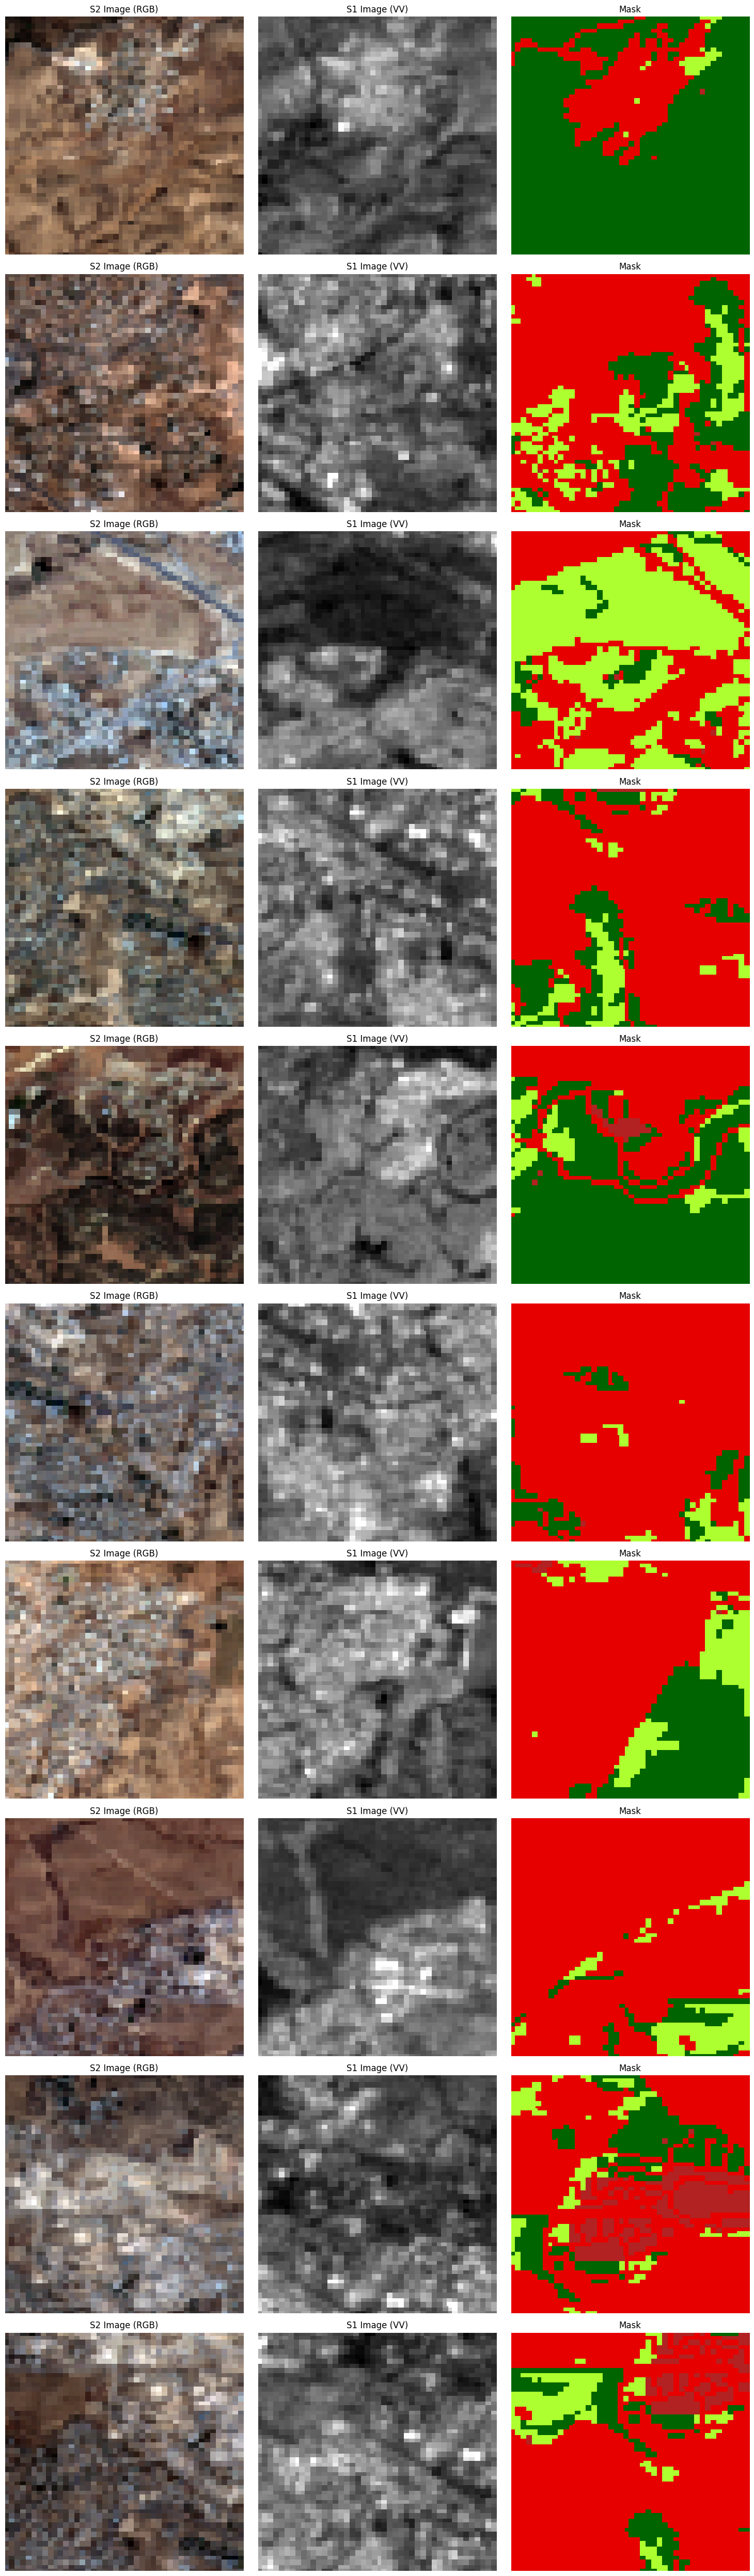

In [ ]:
print(f"Reading back {OUTPUT_FILE} to verify...")

# --- 1. Define the parsing function ---
def parse_tfrecord(example_proto):
    kernel_shape = [PATCH_SIZE, PATCH_SIZE]

    features_dict = {}
    for f in FEATURE_NAMES:
        features_dict[f] = tf.io.FixedLenFeature(shape=kernel_shape, dtype=tf.float32)

    features_dict[LABEL_NAME] = tf.io.FixedLenFeature(shape=kernel_shape, dtype=tf.int64)

    return tf.io.parse_single_example(example_proto, features_dict)

# --- 2. Load the dataset ---
try:
    dataset = tf.data.TFRecordDataset(OUTPUT_FILE, compression_type="GZIP")
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.take(10)
    dataset_list = list(dataset)
except tf.errors.NotFoundError:
    print(f"ERROR: Output file not found at {OUTPUT_FILE}")
    raise
except Exception as e:
    print(f"An error occurred reading the TFRecord: {e}")
    raise

# --- 3. Plot the samples ---
if not dataset_list:
    print("No data found in the TFRecord file. Was the sampling successful?")
else:
    print(f"Displaying {len(dataset_list)} sample patches...")
    plt.figure(figsize=(15, 5 * len(dataset_list)))
    plot_index = 1

    # --- ADDED FLAG TO PRINT STATS ONLY ONCE ---
    printed_stats = False

    for data in dataset_list:
        try:
            # --- THIS IS THE FIX ---
            # Get the numpy arrays for S2 bands
            red_band = data['B4'].numpy()
            green_band = data['B3'].numpy()
            blue_band = data['B2'].numpy()

            # --- PRINT DATA RANGE (only for the first patch) ---
            if not printed_stats:
                print("\n--- S2 Band Statistics (First Patch) ---")
                print(f"  Red (B4)  - Min: {red_band.min():.4f}, Max: {red_band.max():.4f}, Mean: {red_band.mean():.4f}")
                print(f"  Green (B3) - Min: {green_band.min():.4f}, Max: {green_band.max():.4f}, Mean: {green_band.mean():.4f}")
                print(f"  Blue (B2) - Min: {blue_band.min():.4f}, Max: {blue_band.max():.4f}, Mean: {blue_band.mean():.4f}")
                print("------------------------------------------")
                print("Based on these stats, adjust the 'in_range' argument below for better visuals.")
                printed_stats = True

            # --- Create S2 RGB composite ---
            # We rescale using the image's OWN min/max to force a stretch
            # For a permanent fix, change in_range to sensible values
            # e.g., if max is ~0.4, use in_range=(0, 0.4)
            # e.g., if max is ~10000, use in_range=(0, 10000)

            # OPTION 1: Automatic stretch (will show data)
            s2_rgb = np.dstack([
                rescale_intensity(red_band,   in_range=(red_band.min(), red_band.max()),     out_range=(0, 1)),
                rescale_intensity(green_band, in_range=(green_band.min(), green_band.max()), out_range=(0, 1)),
                rescale_intensity(blue_band,  in_range=(blue_band.min(), blue_band.max()),  out_range=(0, 1))
            ])

            # OPTION 2: Manual stretch (REPLACE with your values after seeing the printout)
            # If your data is 0-1 Surface Reflectance, try this:
            # s2_rgb = np.dstack([
            #     rescale_intensity(red_band,   in_range=(0.0, 0.3), out_range=(0, 1)),
            #     rescale_intensity(green_band, in_range=(0.0, 0.3), out_range=(0, 1)),
            #     rescale_intensity(blue_band,  in_range=(0.0, 0.3), out_range=(0, 1))
            # ])

        except KeyError:
            print("Could not find 'B4', 'B3', 'B2' for RGB plot. Check S2_BANDS in Cell 5.")
            s2_rgb = np.zeros((PATCH_SIZE, PATCH_SIZE, 3)) # Black image

        # --- Create S1 VV composite ---
        try:
            s1_vv_band = data['VV'].numpy()
            s1_vv = rescale_intensity(s1_vv_band, in_range=(-25, 0), out_range=(0, 1))
        except KeyError:
            print("Could not find 'VV' for S1 plot. Check S1_BANDS in Cell 5.")
            s1_vv = np.zeros((PATCH_SIZE, PATCH_SIZE))

        # --- Get the mask ---
        mask_array = data[LABEL_NAME].numpy()

        # --- Plot S2 Image ---
        plt.subplot(len(dataset_list), 3, plot_index)
        plt.imshow(np.clip(s2_rgb, 0, 1))
        plt.title("S2 Image (RGB)")
        plt.axis('off')
        plot_index += 1

        # --- Plot S1 Image ---
        plt.subplot(len(dataset_list), 3, plot_index)
        plt.imshow(s1_vv, cmap='gray')
        plt.title("S1 Image (VV)")
        plt.axis('off')
        plot_index += 1

        # --- Plot Mask ---
        plt.subplot(len(dataset_list), 3, plot_index)
        plt.imshow(mask_array, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
        plt.title("Mask")
        plt.axis('off')
        plot_index += 1

    plt.tight_layout()
    plt.show()